In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# text processing libraries
import re
import nltk
from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

import spacy
nlp = spacy.load('en_core_web_sm')

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### EDA

<AxesSubplot:xlabel='keyword'>

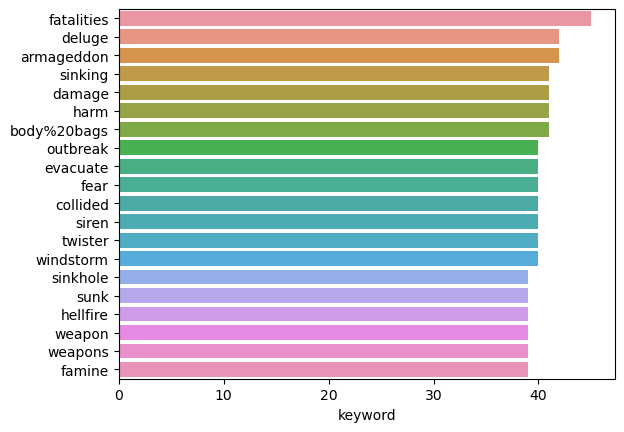

In [4]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20], orient='h')

<AxesSubplot:xlabel='location'>

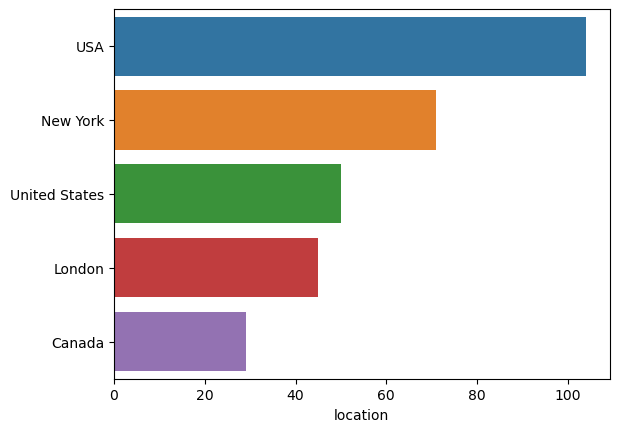

In [5]:
sns.barplot(y=train['location'].value_counts()[:5].index,
            x=train['location'].value_counts()[:5], orient='h')

Text(0.5, 1.0, 'Countplot for Disaster and Non-disaster Related Tweets')

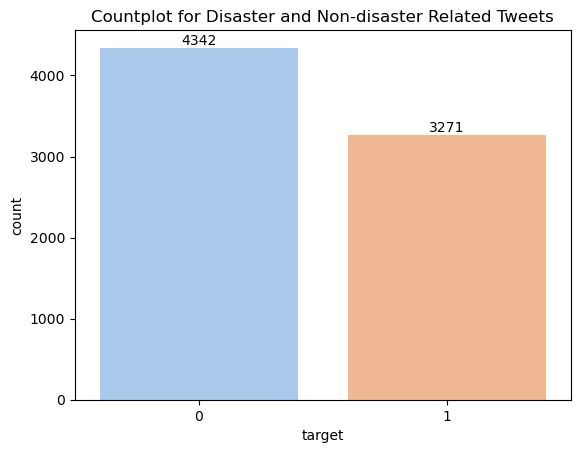

In [6]:
ax = sns.countplot(data=train, x='target', palette='pastel')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Countplot for Disaster and Non-disaster Related Tweets')

In [7]:
train.drop(columns=['id','location','keyword'], inplace=True)
train = train.drop_duplicates(["text", "target"])

### Cleaning

In [8]:
train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7604    #WorldNews Fallen powerlines on G:link tram: U...
7605    on the flip side I'm at Walmart and there is a...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7521, dtype: object

In [9]:
def expand_hashtags(s: str):
    """ Convert string with hashtags """
    s_out = s
    for tag in re.findall(r'#\w+', s):
        s_out = s_out.replace(tag, expand_hashtag(tag))
    return s_out

def remove_last_hashtags(s: str):
    """ Remove all hashtags at the end of the text except #url """
    tokens = TweetTokenizer().tokenize(s)
    # If the URL was added, keep it
    url = "#url" if "#url" in tokens else None
    # Remove hashtags
    while len(tokens) > 0 and tokens[-1].startswith("#"):
        tokens = tokens[:-1]
    # Restore 'url' if it was added
    if url is not None:
        tokens.append(url)
    return ' '.join(tokens)

def expand_hashtag(tag: str):
    """ Convert #HashTag to separated words """
    res = re.findall('[A-Z]+[^A-Z]*', tag)
    return ' '.join(res) if len(res) > 0 else tag[1:]

def remove_stopwords(text) -> str:
    """ Remove stopwords from text """
    filtered_words = [word for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def lemmatize(sentence: str) -> str:
    """ Convert all words in sentence to lemmatized form """
    return " ".join([token.lemma_ for token in nlp(sentence)])

def text_clean(text: str) -> str:
    try:
        output = re.sub(r"https?://\S+", '', text)
        output = re.sub(r"@\w+", '', output)
        output = remove_last_hashtags(output)
        output = expand_hashtag(output)
        output = re.sub("[^a-zA-Z]+", ' ', output)
        output = re.sub(r"\s+", " ", output)
        output = lemmatize(output)
        output = remove_stopwords(output)
        return output.lower().strip()
    except:
        return ''
    
train['text_clean'] = train['text'].map(text_clean)

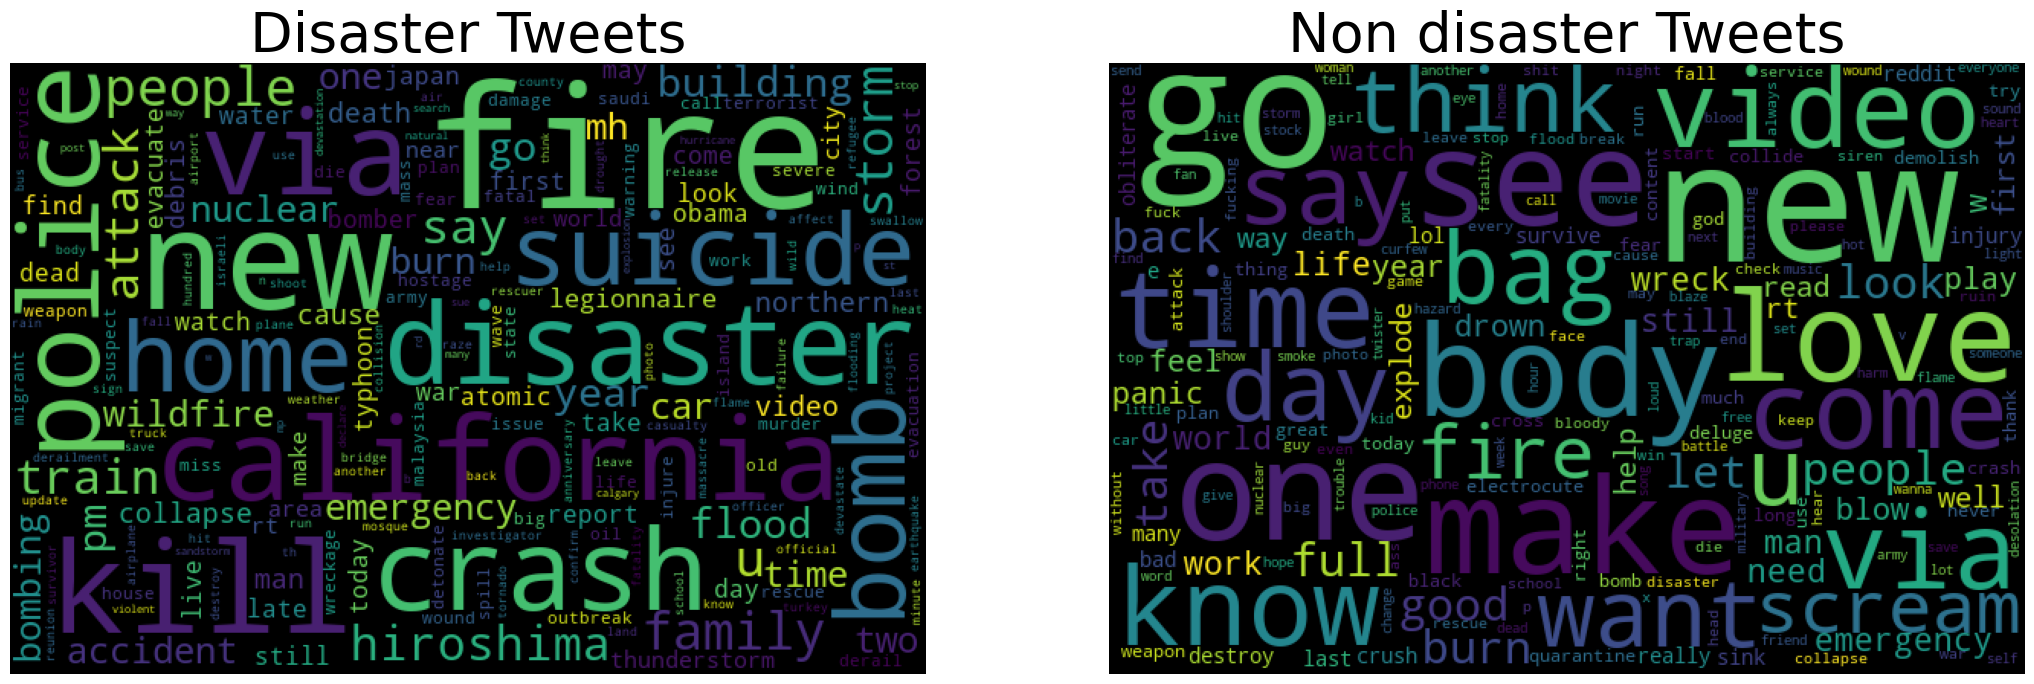

In [10]:
from wordcloud import WordCloud

def draw_cloud(ax, title, column: pd.Series, stopwords=None):
    all_words = ' '.join([text for text in column])
    
    wordcloud = WordCloud(width=600, height=400, random_state=42,
                          max_font_size=110, collocations=False, 
                          stopwords=stopwords).generate(all_words)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(title, fontsize=40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
draw_cloud(ax1, "Disaster Tweets", train[train['target']==1]['text_clean'])
draw_cloud(ax2, "Non disaster Tweets", train[train['target']==0]['text_clean'])

### Feature extraction

In [63]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

docs = train['text_clean'].values
tfidf = TfidfVectorizer()
vectorized_docs = np.array(tfidf.fit_transform(docs).todense())
vectorized_docs.shape

(7521, 11490)

In [17]:
vectorized_docs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_docs, 
                                                    train['target'].values, 
                                                    test_size=0.30, random_state=42)

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [27]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7797961896322552


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1304
           1       0.83      0.60      0.70       953

    accuracy                           0.78      2257
   macro avg       0.79      0.76      0.76      2257
weighted avg       0.79      0.78      0.77      2257



Confusion matrix [[1189  115]
 [ 382  571]]


Text(50.722222222222214, 0.5, 'True')

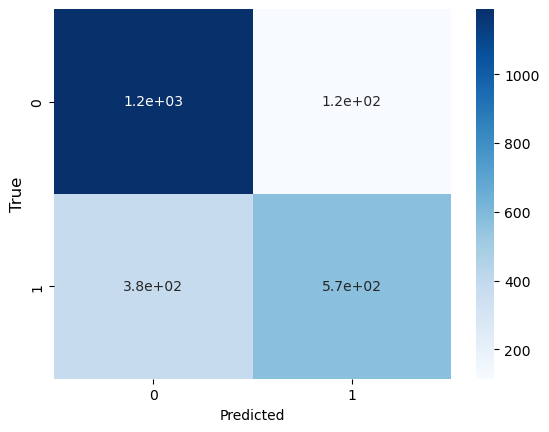

In [29]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['TN','FP','FN','TP']
print("Confusion matrix",cnf_matrix)
sns.heatmap(cnf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)

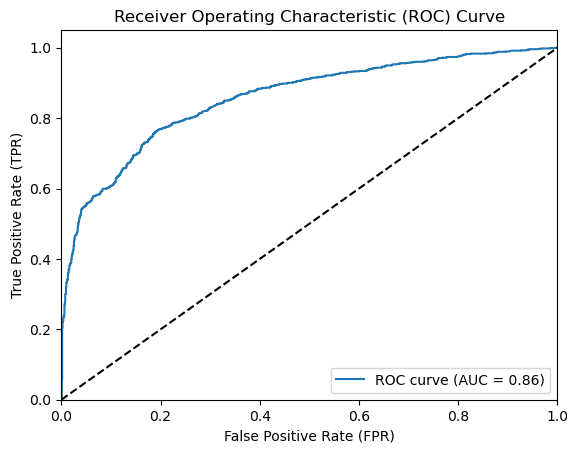

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the predicted probabilities for the test data
y_pred_proba = lr.predict_proba(X_test)

# Extract the probabilities for the positive class (class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes Classifier

In [36]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [37]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.6016836508639787
              precision    recall  f1-score   support

           0       0.74      0.48      0.58      1304
           1       0.52      0.76      0.62       953

    accuracy                           0.60      2257
   macro avg       0.63      0.62      0.60      2257
weighted avg       0.65      0.60      0.60      2257



Confusion matrix [[629 675]
 [224 729]]


Text(50.722222222222214, 0.5, 'True')

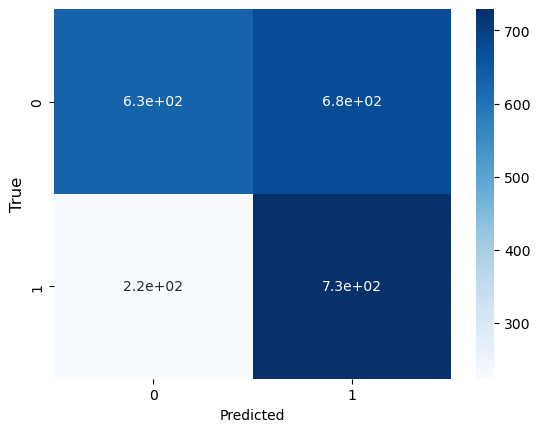

In [38]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['TN','FP','FN','TP']
print("Confusion matrix",cnf_matrix)
sns.heatmap(cnf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)

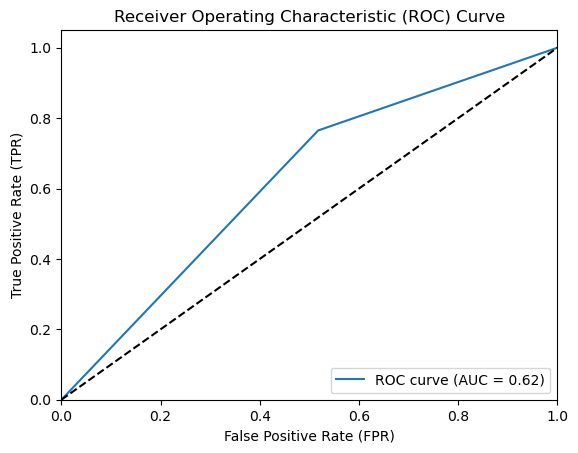

In [39]:
# Calculate the predicted probabilities for the test data
y_pred_proba = nb.predict_proba(X_test)

# Extract the probabilities for the positive class (class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### RandomForestClassifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7806823216659282
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1304
           1       0.81      0.63      0.71       953

    accuracy                           0.78      2257
   macro avg       0.79      0.76      0.77      2257
weighted avg       0.78      0.78      0.78      2257



Confusion matrix [[1159  145]
 [ 350  603]]


Text(50.722222222222214, 0.5, 'True')

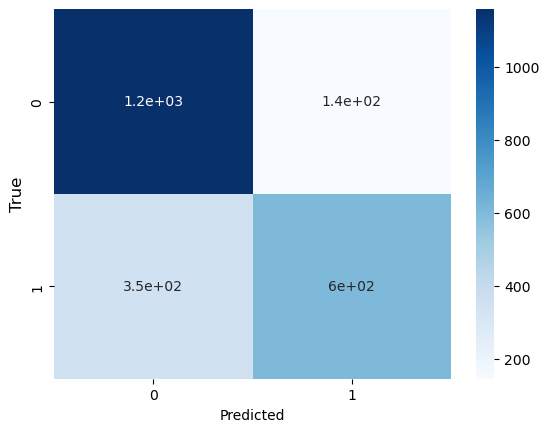

In [42]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['TN','FP','FN','TP']
print("Confusion matrix",cnf_matrix)
sns.heatmap(cnf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)

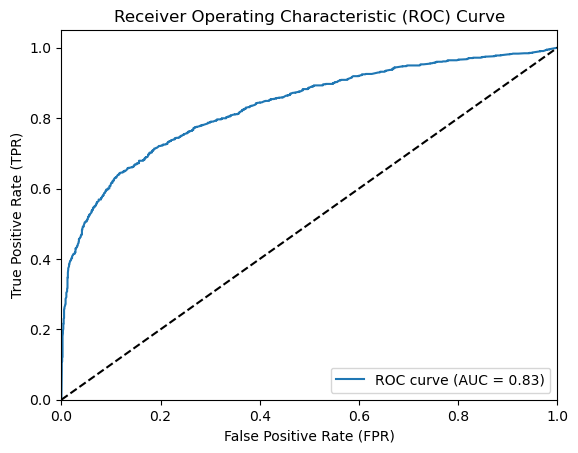

In [43]:
# Calculate the predicted probabilities for the test data
y_pred_proba = rf.predict_proba(X_test)

# Extract the probabilities for the positive class (class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### DecisionTreeClassifier

In [44]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [45]:
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7270713336287107
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1304
           1       0.67      0.69      0.68       953

    accuracy                           0.73      2257
   macro avg       0.72      0.72      0.72      2257
weighted avg       0.73      0.73      0.73      2257



Confusion matrix [[986 318]
 [298 655]]


Text(50.722222222222214, 0.5, 'True')

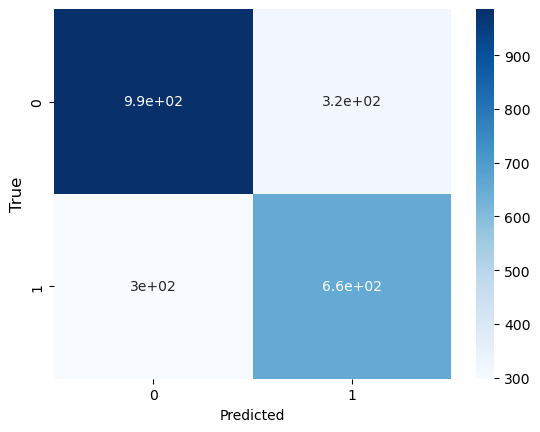

In [46]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['TN','FP','FN','TP']
print("Confusion matrix",cnf_matrix)
sns.heatmap(cnf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)

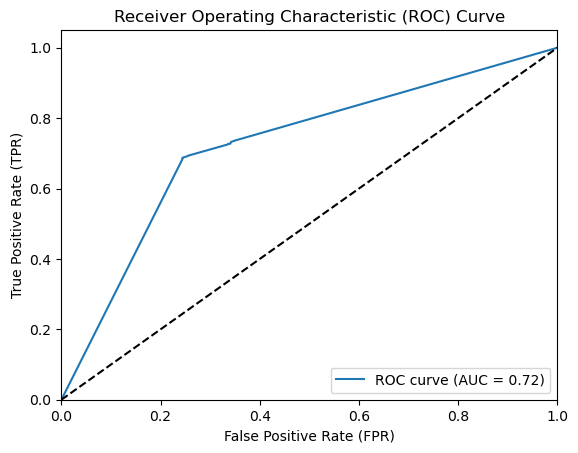

In [47]:
# Calculate the predicted probabilities for the test data
y_pred_proba = dt.predict_proba(X_test)

# Extract the probabilities for the positive class (class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### GradientBoostingClassifier

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [49]:
y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7346034559149314
              precision    recall  f1-score   support

           0       0.70      0.93      0.80      1304
           1       0.84      0.46      0.59       953

    accuracy                           0.73      2257
   macro avg       0.77      0.70      0.70      2257
weighted avg       0.76      0.73      0.71      2257



Confusion matrix [[1218   86]
 [ 513  440]]


Text(50.722222222222214, 0.5, 'True')

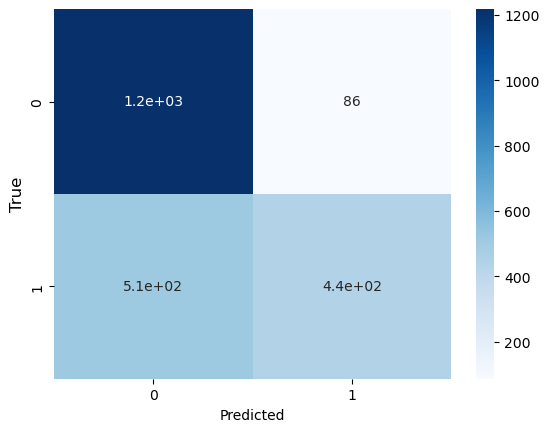

In [50]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['TN','FP','FN','TP']
print("Confusion matrix",cnf_matrix)
sns.heatmap(cnf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)

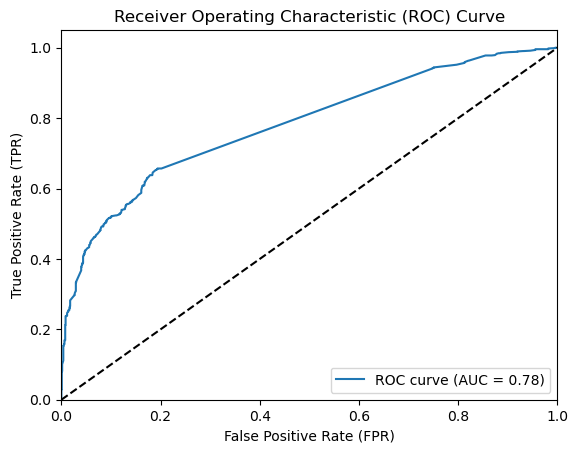

In [51]:
# Calculate the predicted probabilities for the test data
y_pred_proba = gb.predict_proba(X_test)

# Extract the probabilities for the positive class (class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Save model

In [67]:
import joblib

joblib.dump(tfidf, filename='tfidf.joblib')
joblib.dump(rf, filename = 'disaster_model.joblib')

['disaster_model.joblib']